# Env Setup

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import torch
import torchvision
import xml.etree.ElementTree as ET
import yaml

from IPython.display import Image, display
from ipywidgets import IntProgress
from sklearn.model_selection import train_test_split
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from ultralytics import YOLO
from ultralytics.engine.results import Boxes

In [2]:
data_dir = os.path.join('datasets', 'sea_data') # Where will you save the dataset

# Separate directories for images and labels
img_dir = os.path.join(data_dir, 'images') 
label_dir = os.path.join(data_dir, 'labels')

random_seed = 4242
np.random.seed(random_seed)

# Download Images

In [3]:
concepts_to_include = [
    'Actinaria',
    'Annelida',
    'Ascidiacea',
    'Asteroidea',
    'Bivalvia',
    'Bryoza',
    'Ceriantharia',
    'Crinoidea',
    'Echinoidea',
    'Gastropoda',
    'Hexacorallia',
    'Holothuroidea',
    'Octocorallia',
    'Ophiuroidea',
    'Porifera',
    'Pycnogonida'
]

In [4]:
count_command = f'fathomnet-generate -c "{",".join(concepts_to_include)}" --count'
#!{count_command}

In [5]:
install_command = f'fathomnet-generate -c "{",".join(concepts_to_include)}" --format voc --img-download "{img_dir}" --output "{label_dir}"'
#!{install_command}

We are very limitted in space, so after installing we want to ensure that each image looks closest to our final test data these include images that have several labels on them. For this reason we want to ensure that as many of our training images as possible have several labels. We are going to throw away any images that only have one bounding box.

In [6]:
number_of_images = len(os.listdir(label_dir))

image_to_boxes_map = {}
list_of_concept_images = {key: 0 for key in concepts_to_include}

for filename in os.listdir(label_dir):
    if not filename.endswith('.xml'): continue
        
    xml_file_path = os.path.join(label_dir, filename)
    root_name, _ = os.path.splitext(filename)

    image_to_boxes_map[root_name] = []

    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    for obj in root.findall('.//object'):
        name = obj.find('name').text

        image_to_boxes_map[root_name].append(name)
        list_of_concept_images[name] += 1

In [7]:
print(sum(list_of_concept_images.values()))
list_of_concept_images

0


{'Actinaria': 0,
 'Annelida': 0,
 'Ascidiacea': 0,
 'Asteroidea': 0,
 'Bivalvia': 0,
 'Bryoza': 0,
 'Ceriantharia': 0,
 'Crinoidea': 0,
 'Echinoidea': 0,
 'Gastropoda': 0,
 'Hexacorallia': 0,
 'Holothuroidea': 0,
 'Octocorallia': 0,
 'Ophiuroidea': 0,
 'Porifera': 0,
 'Pycnogonida': 0}

In [8]:
def remove_img_and_labels(root_name):
    label_file = os.path.join(label_dir, f"{root_name}.xml")
    img_file = os.path.join(img_dir, f"{root_name}.png")

    removed_file_size = os.path.getsize(label_file) + os.path.getsize(img_file)
    
    os.remove(label_file)
    os.remove(img_file)
    
    return removed_file_size

def has_too_few_boxes(label_set):
    return any(list_of_concept_images[label] <= 50 for label in label_set)

for root_name in list(image_to_boxes_map.keys()):
    boxes = image_to_boxes_map[root_name]
    unique_concepts = set(boxes)
        
    if has_too_few_boxes(unique_concepts):
        remove_img_and_labels(root_name)
        total_size -= amount_removed

        for box in boxes:
            list_of_concept_images[box] -= 1
        del image_to_boxes_map[root_name]


for k, v in list_of_concept_images.copy().items():
    if v == 0:
        del list_of_concept_images[k]
        concepts_to_include.remove(k)

print(sum(list_of_concept_images.values()))
list_of_concept_images

0


{}

In [9]:
def is_more_than_others(concept_names):
    return_param = True
    even_share = 1/len(list_of_concept_images.keys())
    for name in concept_names:
        return_param &= list_of_concept_images[name] > even_share * sum(list_of_concept_images.values())
    return return_param

def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)
    return total_size
    

image_to_boxes_map = dict(sorted(image_to_boxes_map.items(), key=lambda item: len(item[1])))
total_size = get_folder_size(data_dir)

i = 0
j = 1
while total_size / 1024**3 > 7:
    root_name = list(image_to_boxes_map.keys())[i]
    boxes = image_to_boxes_map[root_name]
    unique_concepts = set(boxes)
        
    if len(unique_concepts) <= j and is_more_than_others(unique_concepts):
        amount_removed = remove_img_and_labels(root_name)
        total_size -= amount_removed
        
        for box in boxes:
            list_of_concept_images[box] -= 1
        del image_to_boxes_map[root_name]
    else:
        i += 1

    i %= len(image_to_boxes_map.keys())
    if i == 0:
        j += 1
        total_size = get_folder_size(data_dir)

print(sum(list_of_concept_images.values()))  
list_of_concept_images

IndexError: list index out of range

In [10]:
len(image_to_boxes_map)

0

In [11]:
get_folder_size(data_dir) / 1024**3

7.1184872249141335

In [12]:
### DELETE THIS
concepts_to_include= [ 'Asteroidea',
 'Bivalvia',
 'Ceriantharia',
 'Crinoidea',
 'Gastropoda',
 'Hexacorallia',
 'Holothuroidea',
 'Octocorallia',
 'Ophiuroidea',
 'Porifera',
 'Pycnogonida']
concepts_to_include

['Asteroidea',
 'Bivalvia',
 'Ceriantharia',
 'Crinoidea',
 'Gastropoda',
 'Hexacorallia',
 'Holothuroidea',
 'Octocorallia',
 'Ophiuroidea',
 'Porifera',
 'Pycnogonida']

## Test and display

In [13]:
def parseXml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bbox_pair = []

    for obj in root.findall('object'):
        name_key = obj.find('name').text
    
        x0 = int(obj.find('bndbox/xmin').text)
        y0 = int(obj.find('bndbox/ymin').text)
        x1 = int(obj.find('bndbox/xmax').text)
        y1 = int(obj.find('bndbox/ymax').text)

        bbox_pair.append((name_key, (x0, y0, x1, y1)))
    
    return bbox_pair

def draw_boxes(image, bboxes):
    for label, (x0, y0, x1, y1) in bboxes:
        cv2.rectangle(image, (int(x0), int(y0)), (int(x1), int(y1)), (0, 255, 0), 2)
        cv2.putText(image, label, (x0, y0 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2)
    
    return image

import math

def display_images(images):
    dimension = math.ceil(len(images) ** 0.5)

    fig, axes = plt.subplots(dimension, dimension, figsize=(20, 20))  # Adjust the figsize as needed

    for i in range(dimension):
        for j in range(dimension):
            image_index = i * dimension + j
            if image_index < len(images):
                axes[i, j].imshow(cv2.cvtColor(images[image_index], cv2.COLOR_BGR2RGB))  # Convert to RGB format
                axes[i, j].axis('off')  # Hide axis labels
            else:
                axes[i, j].axis('off')  # Hide the empty grid cell
    
    plt.show()

In [14]:
imgs_to_show = {}
for uid, concepts in image_to_boxes_map.items():
    concept_name = [name for name in concepts if name not in imgs_to_show]
    
    if concept_name:
        imgs_to_show[concept_name[0]] = uid

    if imgs_to_show.keys() == list_of_concept_images.keys():
        break

images_to_display = []
for uid in list(imgs_to_show.values()):
    image_path = os.path.join(img_dir, f"{uid}.png")
    image = cv2.imread(image_path)
    bboxes = parseXml(os.path.join(data_dir, 'labels', f"{uid}.xml"))
    
    images_to_display.append(draw_boxes(image, bboxes))

#display_images(images_to_display)

## Start to move images for training

In [15]:
yolo_config_name = 'fathomnet'

train_dir = 'train'
val_dir = 'test'

def create_yaml_file(yaml_name=yolo_config_name):
    data = {
        "path": 'sea_data',
        "train": [os.path.join('images', train_dir)],
        "val": [os.path.join('images', val_dir)],
        "test": [os.path.join('images', val_dir)],
        "names": {str(idx): class_name for idx, class_name in enumerate(concepts_to_include)}
    }

    with open(os.path.join(data_dir, f"{yaml_name}.yaml"), "w") as yaml_file:
        yaml.dump(data, yaml_file, default_flow_style=False)

#create_yaml_file()

In [16]:
def copyImageToLocation(uid, dest_dir=train_dir):
    src_file = os.path.join(img_dir, f"{uid}.png")

    if not os.path.isfile(os.path.join(img_dir, f"{uid}.png")):
        return
        
    os.makedirs(os.path.join(img_dir, dest_dir), exist_ok=True)
    dest_file = os.path.join(img_dir, dest_dir, f"{uid}.png")

    shutil.move(src_file, dest_file)

In [17]:
def createTxtFile(uid, dest_dir=train_dir):
    if not os.path.isfile(os.path.join(label_dir, f"{uid}.xml")):
        return
    
    image = cv2.imread(os.path.join(img_dir, dest_dir, f"{uid}.png"))
    try:
        img_height, img_width, _ = image.shape
    except:
        os.remove(os.path.join(img_dir, dest_dir, f"{uid}.png"))
        os.remove(os.path.join(img_dir, f"{uid}.png"))
        os.remove(os.path.join(label_dir, f"{uid}.xml"))
        return

    source_path = os.path.join(label_dir, f'{uid}.xml')
    concept_to_bbox_map = parseXml(source_path)

    file_destination = os.path.join(label_dir, dest_dir)
    os.makedirs(file_destination, exist_ok=True)

    output_xml_path = os.path.join(file_destination, f'{uid}.xml')
    shutil.move(source_path, output_xml_path)

    with open(os.path.join(file_destination, f'{uid}.txt'), 'w') as txt_file:
        for concept, (x0, y0, x1, y1)  in concept_to_bbox_map:
            name_key = concepts_to_include.index(concept)
    
            xcenter_norm = ((x0 + x1) / 2) / img_width
            ycenter_norm = ((y0 + y1) / 2) / img_height
            width_norm = (x1 - x0) / img_width
            height_norm = (y1 - y0) / img_height
    
            line = f"{name_key} {xcenter_norm:6f} {ycenter_norm:6f} {width_norm:6f} {height_norm:6f}"
            txt_file.write(line + '\n')

In [18]:
img_index = 0

progress = IntProgress(min=0, max=len(os.listdir(label_dir)))
display(progress)

def createNewFiles(files, target_dir=train_dir):
    global img_index
    for file in files:
        img_index += 1
        progress.value = img_index
        copyImageToLocation(file, target_dir)
        createTxtFile(file, target_dir)


IntProgress(value=0, max=5)

In [19]:
train_size = 0.7
val_size = 0.3

file_list = [os.path.splitext(file)[0] for file in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, file))]

train_files, val_files = train_test_split(file_list, test_size=val_size, random_state=random_seed)

#createNewFiles(train_files, train_dir)
#createNewFiles(val_files, val_dir)

ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

## Sample moved images

In [20]:
def get_corners(mid_norm, dist_norm, dist_abs):
    top_corner_abs = int((mid_norm - dist_norm / 2) * dist_abs)
    bot_corner_abs = int((mid_norm + dist_norm / 2) * dist_abs)
    return top_corner_abs, bot_corner_abs

def parse_txt(text_path, image_size):
    h, w, _ = image_size    
    bbox_pair = []
    
    with open(text_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            
            label = concepts_to_include[int(parts[0])]
            x_mid, y_mid, w_norm, h_norm = map(float, parts[1:])
                    
            x0, x1 = get_corners(x_mid, w_norm, w)
            y0, y1 = get_corners(y_mid, h_norm, h)
                
            bbox_pair.append((label, (x0, y0, x1, y1)))

    return bbox_pair

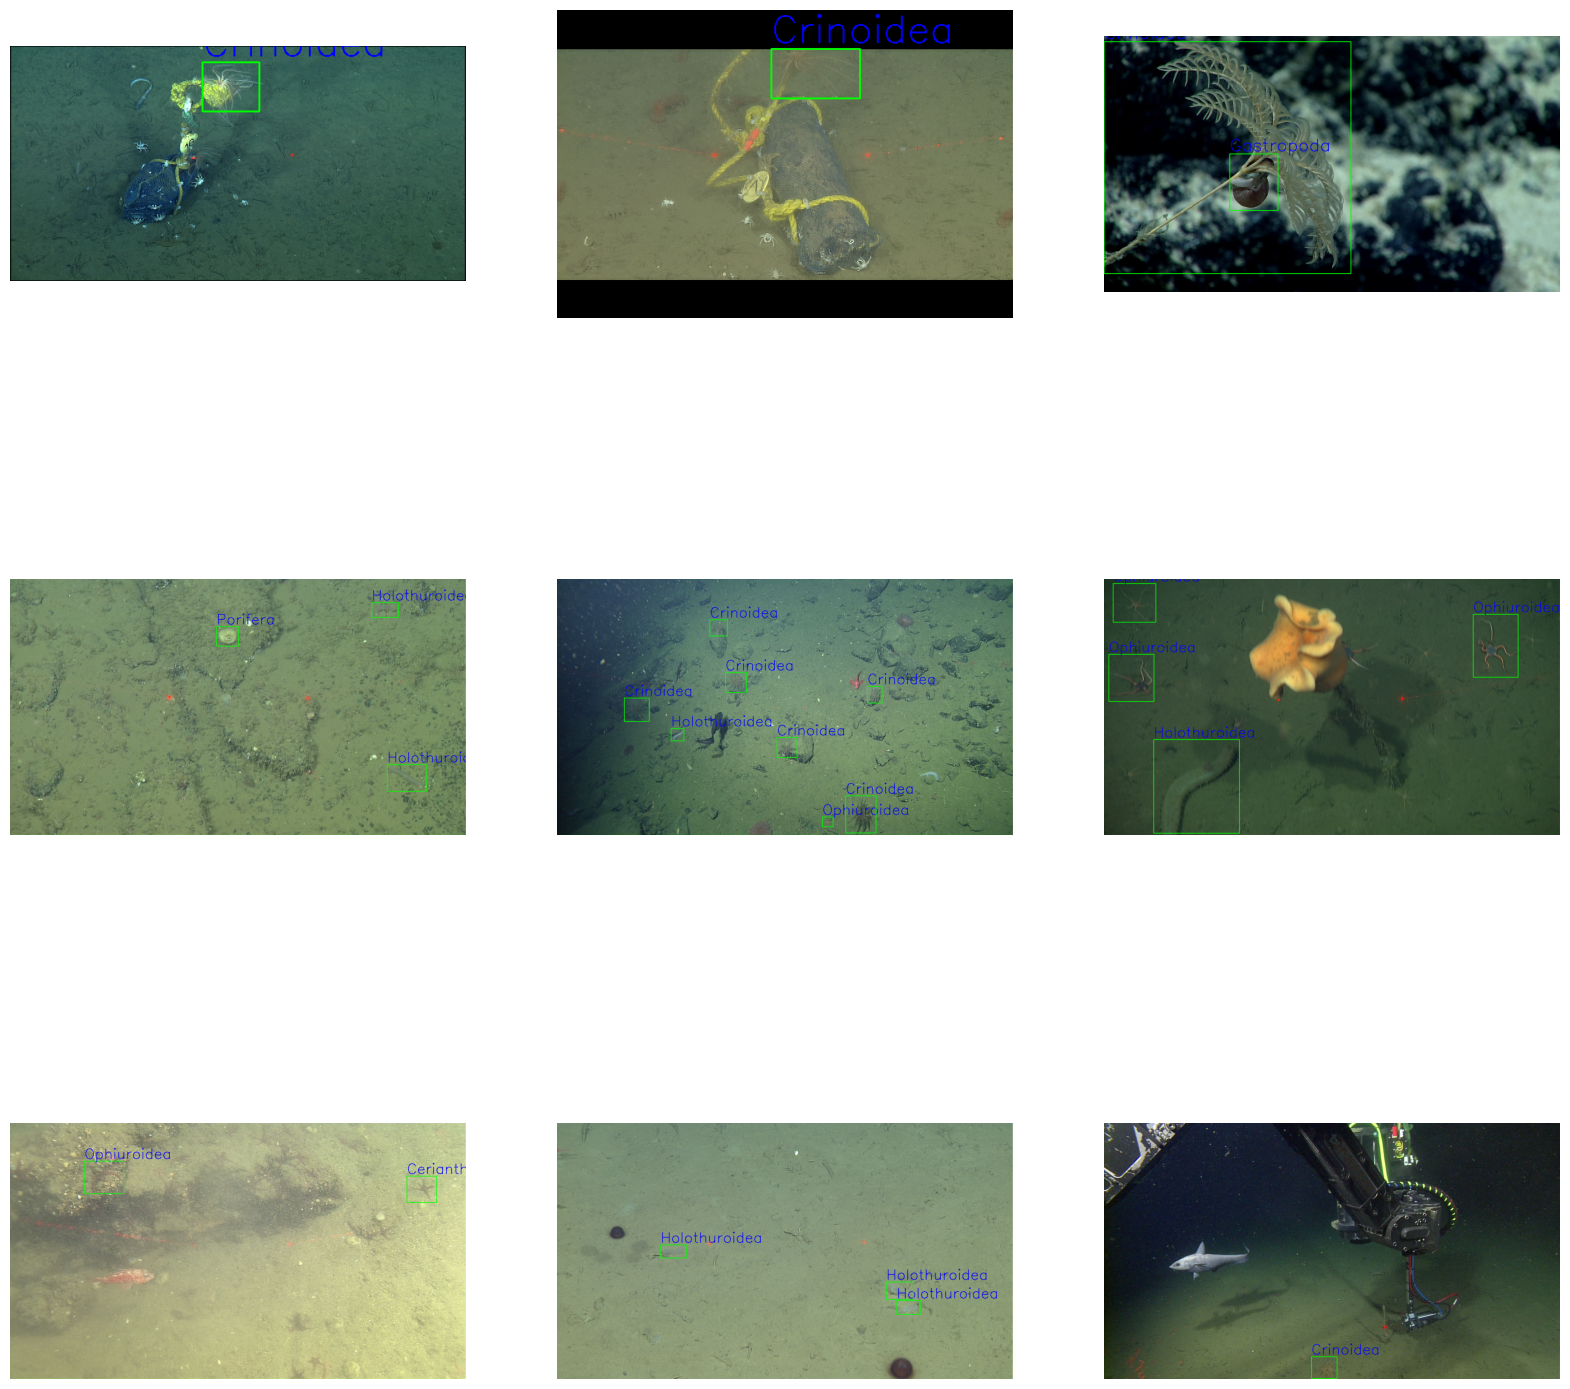

In [21]:
dimensions = 3

target_dir = os.path.join(img_dir, train_dir)
random_images = np.random.choice(os.listdir(target_dir), dimensions ** 2, replace=False)

images_to_display = []
for file in random_images:
    uid, _ = os.path.splitext(file)
    
    image_path = os.path.join(target_dir, file)
    image = cv2.imread(image_path)

    bboxes = parse_txt(os.path.join(label_dir, train_dir, f"{uid}.txt"), image.shape)
    
    images_to_display.append(draw_boxes(image, bboxes))
display_images(images_to_display)

## Train YOLO model

In [22]:
device = "0" if torch.cuda.is_available() else "cpu"
if device == "0":
    print("... Using GPU ...")
    torch.cuda.set_device(0)

if os.path.isfile('yolobest.pt'):
    model = YOLO('yolobest.pt')
else:
    model = YOLO('yolov8n.pt')
    model_config = os.path.join(data_dir, f"{yolo_config_name}.yaml")
    #results = model.train(data=model_config, epochs=1)
    #results = model.tune(data=model_config, epochs=5, iterations=50, optimizer='AdamW', plots=False, save=False, val=False)    
    results = model.tune(data=model_config, epochs=30, iterations=300, optimizer='AdamW', save=False, val=False)

... Using GPU ...



0: 640x640 5 Crinoideas, 16 Ophiuroideas, 2.4ms
Speed: 2.5ms preprocess, 2.4ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /home/kyle/Documents/ml_projects/ultralytics/runs/detect/predict4


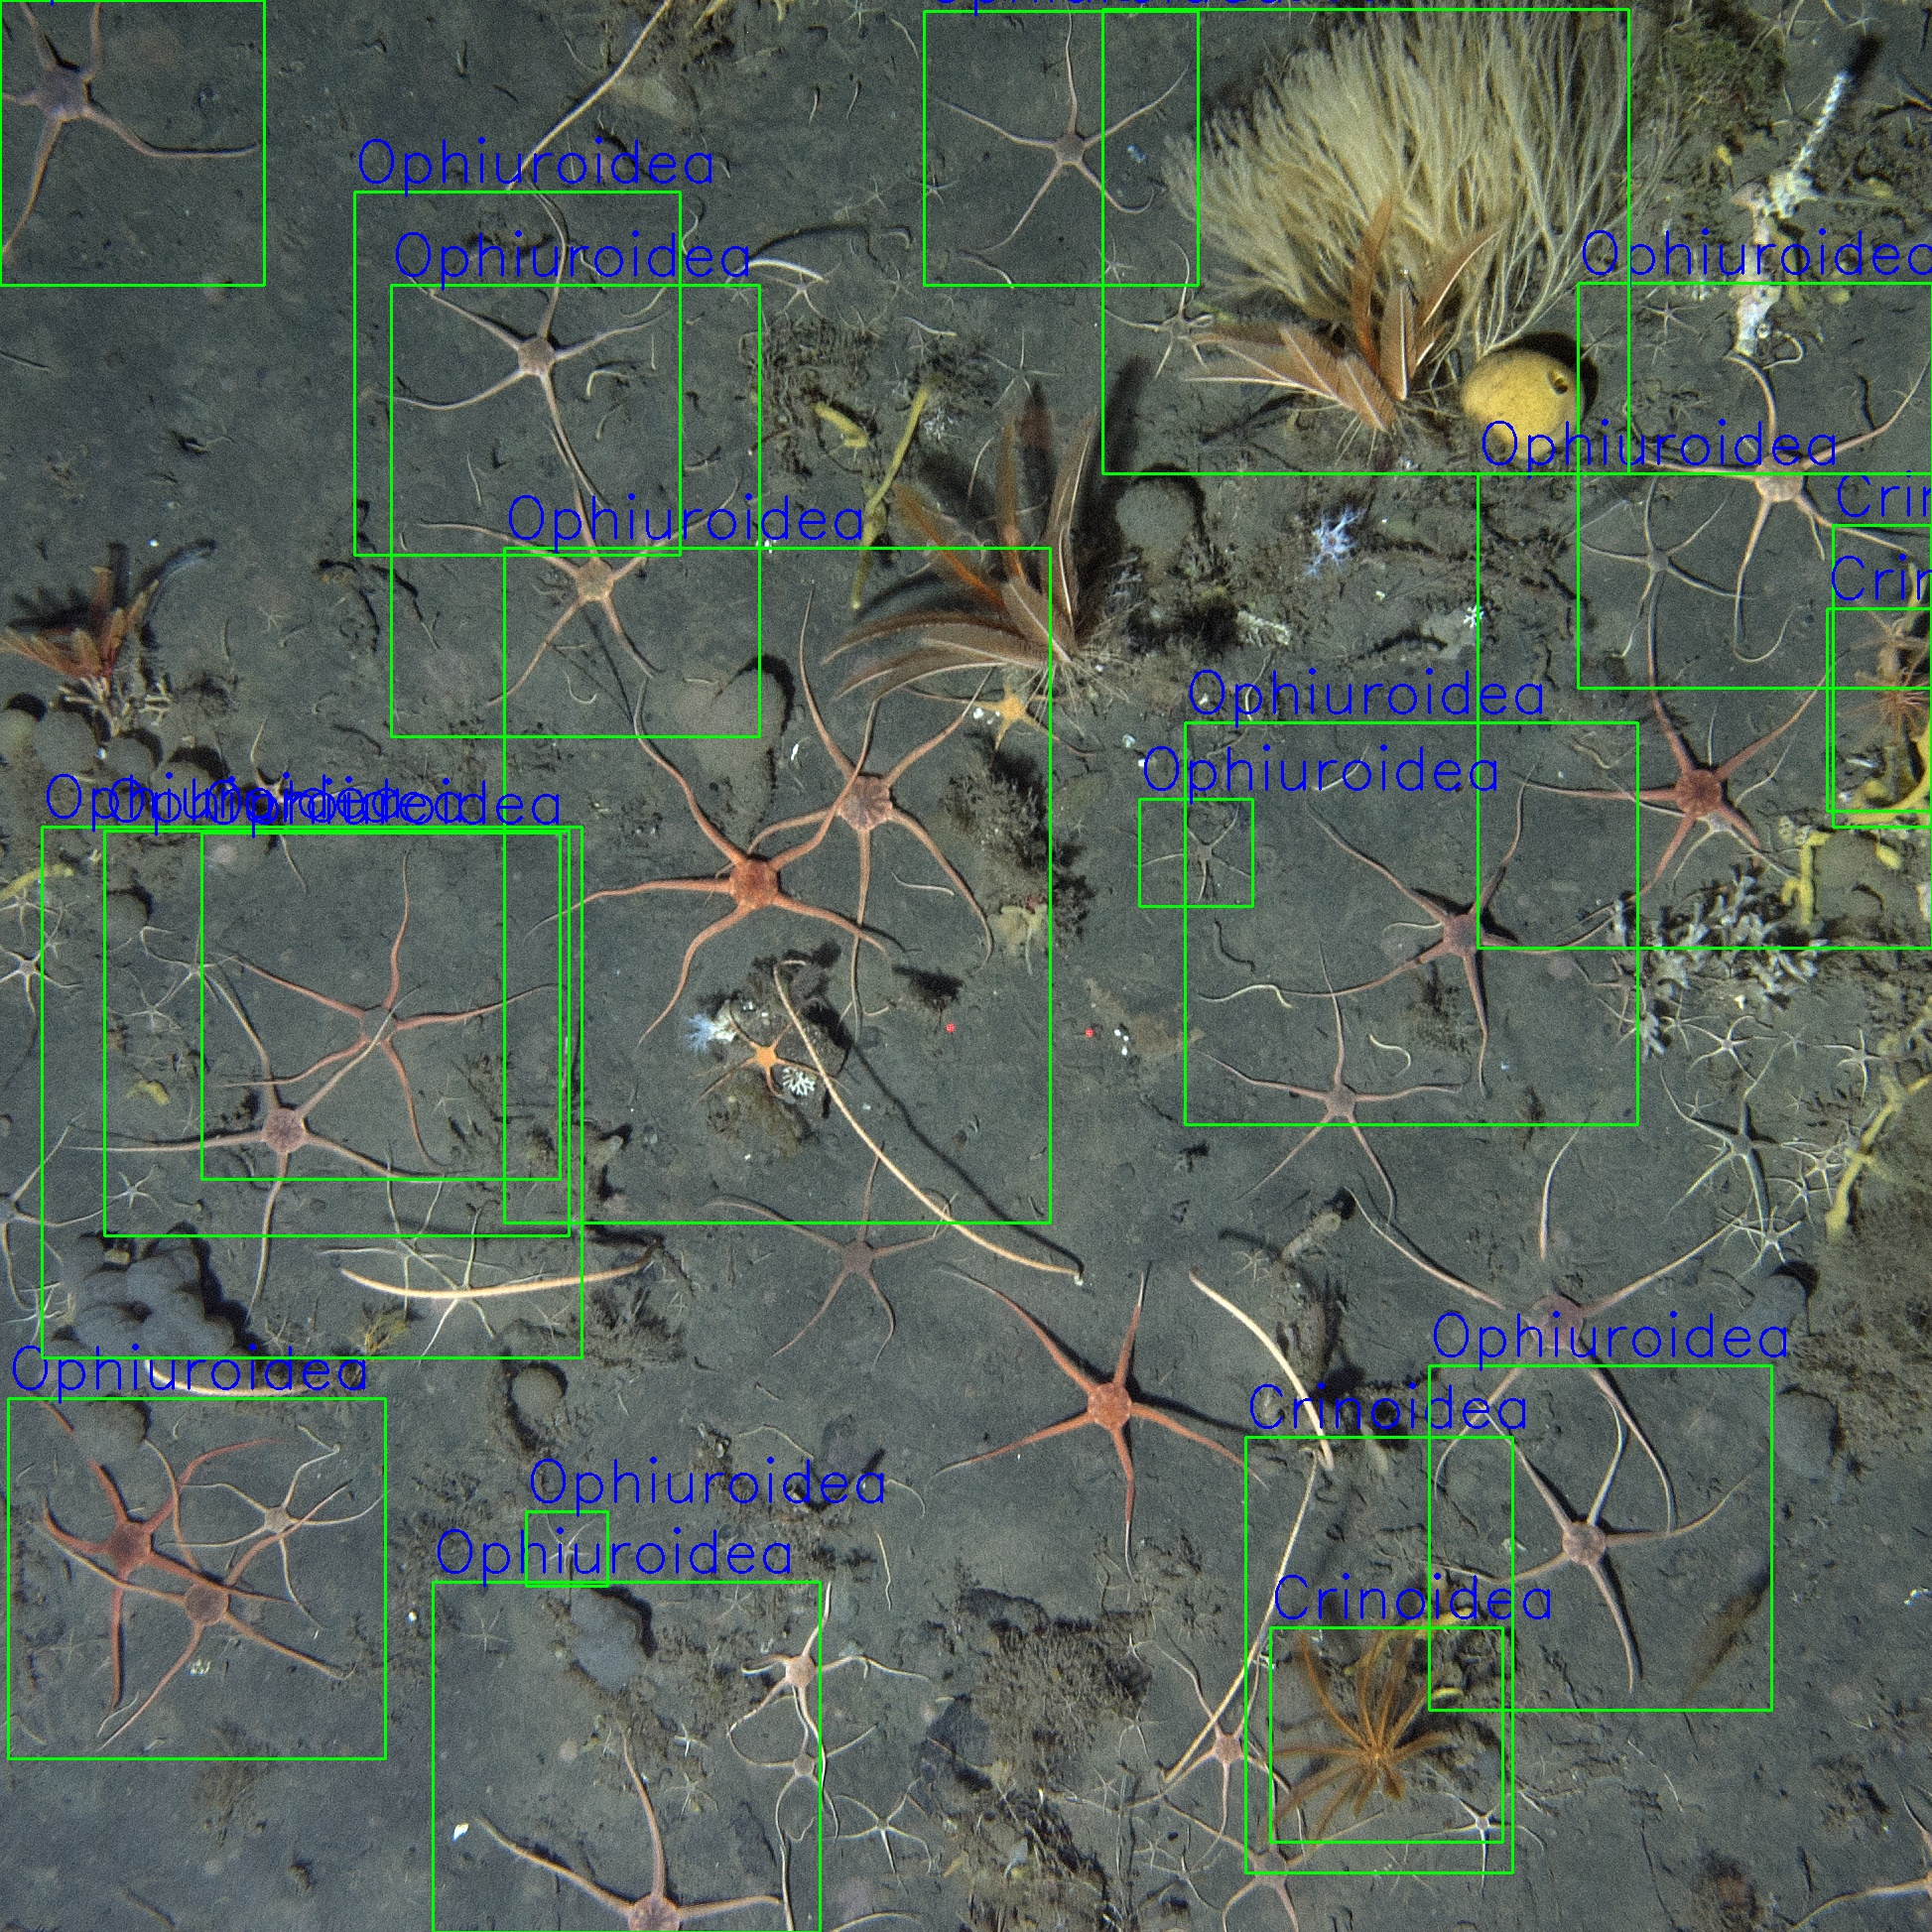

In [23]:
image = cv2.imread('AI_DSC0068_edited.tif')
prediction = model(image, conf=0.07, save=True)

bbox_tuples = [(concepts_to_include[int(bbox.cls)], bbox.xyxy.cpu()[0].numpy().astype(int)) for bbox in prediction[0].boxes]
display(Image(data=cv2.imencode('.jpeg', draw_boxes(image, bbox_tuples))[1].tobytes()))

In [29]:
names_from = ['Annelid', 'Arthrapod', 'Arthrapod_-', 'Ascidiacea', 'Asteroid', 
              'Bryozoan - Cniberian', 'Cnidaria', 'Cnidaria_-', 'Crinoid', 
              'Ctenophore', 'Echinoid', 'Fish', 'Holothuroid', 'Holothuroid_-', 
              'Mollusc', 'Ophiuroid', 'Porifera', 'Porifera_-', 'Pycnogonid']
names_to = concepts_to_include

In [30]:
concepts_to_include

['Asteroidea',
 'Bivalvia',
 'Ceriantharia',
 'Crinoidea',
 'Gastropoda',
 'Hexacorallia',
 'Holothuroidea',
 'Octocorallia',
 'Ophiuroidea',
 'Porifera',
 'Pycnogonida']

In [35]:
label_map = {
    str(names_from.index('Asteroid')): str(names_to.index('Asteroidea')),
    str(names_from.index('Crinoid')): str(names_to.index('Crinoidea')),
    str(names_from.index('Holothuroid')): str(names_to.index('Holothuroidea')),
    str(names_from.index('Holothuroid_-')): str(names_to.index('Holothuroidea')),
    str(names_from.index('Ophiuroid')): str(names_to.index('Ophiuroidea')),
    str(names_from.index('Porifera')): str(names_to.index('Porifera')),
    str(names_from.index('Porifera_-')): str(names_to.index('Porifera')),
}

label_map

{'4': '0', '8': '3', '12': '6', '13': '6', '15': '8', '16': '9', '17': '9'}

In [36]:
test_path = os.path.join(label_dir, 'val')

def edit_txt_file(name):
    file_path = os.path.join(test_path, name)

    with open(file_path, 'r+') as file:
        lines = file.readlines()
        file.seek(0)

        for line in lines:
            parts = line.strip().split(" ")

            modified_line = ''
            if parts[0].isdigit() and parts[0] in label_map.keys():
                parts[0] = str(label_map[parts[0]])
                modified_line = ' '.join(parts) + '\n'

            file.write(modified_line)
        file.truncate()

for file in os.listdir(test_path):
    edit_txt_file(file)

In [57]:
metrics = model.val(conf=0.3)
print(metrics.box.map)

Ultralytics YOLOv8.0.203 🚀 Python-3.8.10 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3070, 7940MiB)
val: Scanning /home/kyle/Documents/ml_projects/datasets/sea_data/labels/val.cach
                 Class     Images  Instances      Box(P          R      mAP50  m
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5818235940>
Traceback (most recent call last):
  File "/home/kyle/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/kyle/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 931, in wa

0.1759245222122241
